In [1]:
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt

In [2]:
# params
N = 1
Ns = 4
Na = 4
T = 10
dt = 0.1        # TODO get val from env
tau = 0.25      # TODO get val from env
sensitivity = 5 # TODO get val from env
eps = 1e-3
Q = np.zeros((Ns,Ns))
R = np.eye(Na)

T_traj = 100

In [3]:
# dynamics
A = np.array([[0, 0, 1, 0], 
              [0, 0, 0, 1], 
              [0, 0, -tau/dt, 0], 
              [0, 0, 0, -tau/dt]])
B = np.array([[0, 0, 0, 0], 
              [0, 0, 0, 0], 
              [1, -1, 0, 0], 
              [0, 0, 1, -1]]) 

Ad = np.eye(Ns) + A*dt
Bd = B*dt*sensitivity

In [4]:
# initial state
x = 0.5 * np.ones((4, 1))

# store trajectory
x_traj = [x]
u_traj = []

In [5]:
# compute trajectory
for i in range(T_traj):
  u = np.random.uniform(0, 1, (Ns, 1))
  x = Ad @ x + Bd @ u
  x_traj.append(x)
  u_traj.append(u)

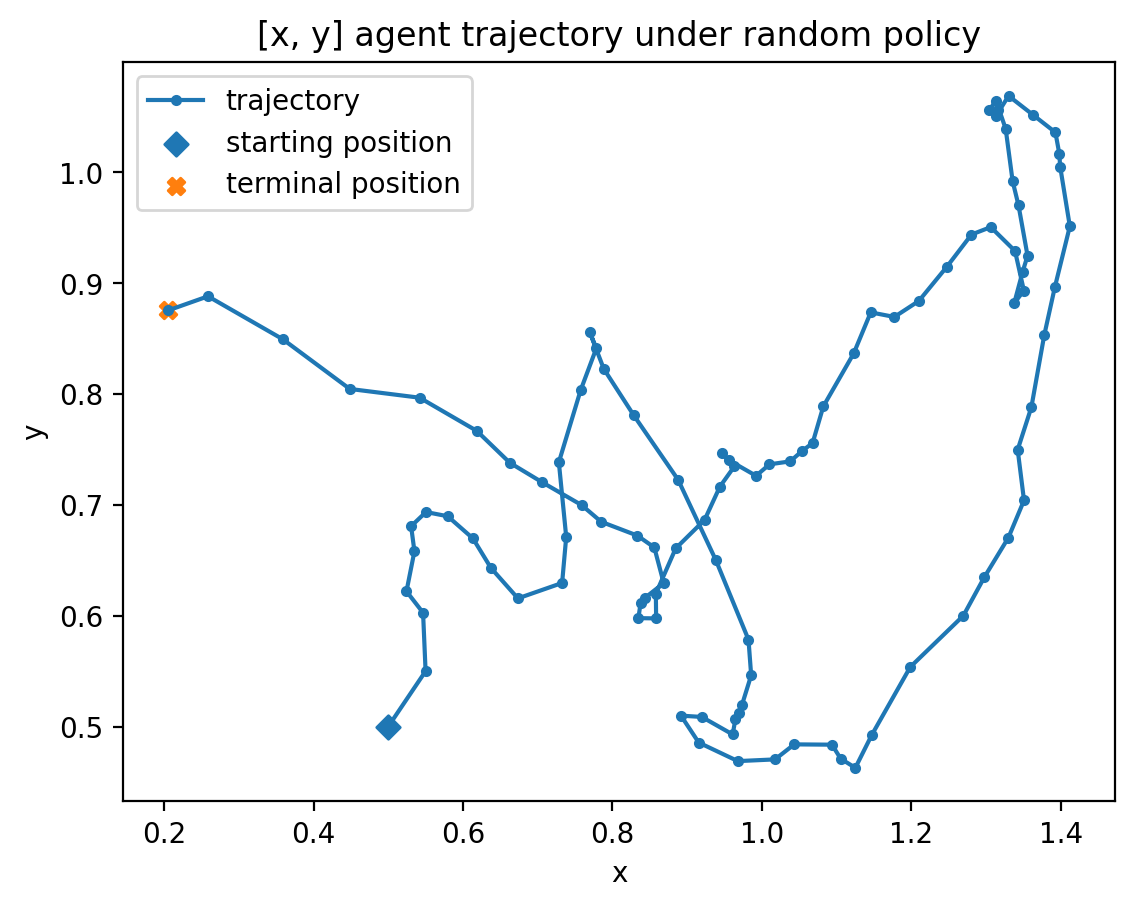

In [6]:
x_traj_np = np.hstack(x_traj)
plt.figure(dpi=200)
plt.plot(x_traj_np[0,:], x_traj_np[1,:], '.-', label="trajectory")
plt.scatter(x_traj_np[0,0], x_traj_np[1,0], marker='D', label="starting position")
plt.scatter(x_traj_np[0,-1], x_traj_np[1,-1], marker='X', label="terminal position")
plt.title("[x, y] agent trajectory under random policy")
plt.xlabel("x")
plt.ylabel("y")
plt.legend(loc="best")

In [7]:
Acp = cp.Variable((4, 4))
Bcp = cp.Variable((4, 4))

obj = cp.Minimize(cp.norm(Acp) + cp.norm(Bcp))
constraints = []
x_prev = x_traj[0]
for x, u in zip(x_traj[1:], u_traj):
  constraints += [x == Acp @ x_prev + Bcp @ u]
  x_prev = x 

# solve
prob = cp.Problem(obj, constraints)
res = prob.solve()
# solution
Ad_p = Acp.value
Bd_p = Bcp.value

In [8]:
ex_traj = []

x = 0.5*np.ones((4,1))
x_p = x.copy()

# compute trajectory
for i in range(T_traj):
  u = np.random.uniform(0, 1, (Ns, 1))
  x = Ad @ x + Bd @ u
  x_p = Ad_p @ x_p + Bd_p @ u
  ex_traj.append(abs(x-x_p))
  
ex_traj = np.hstack(ex_traj)

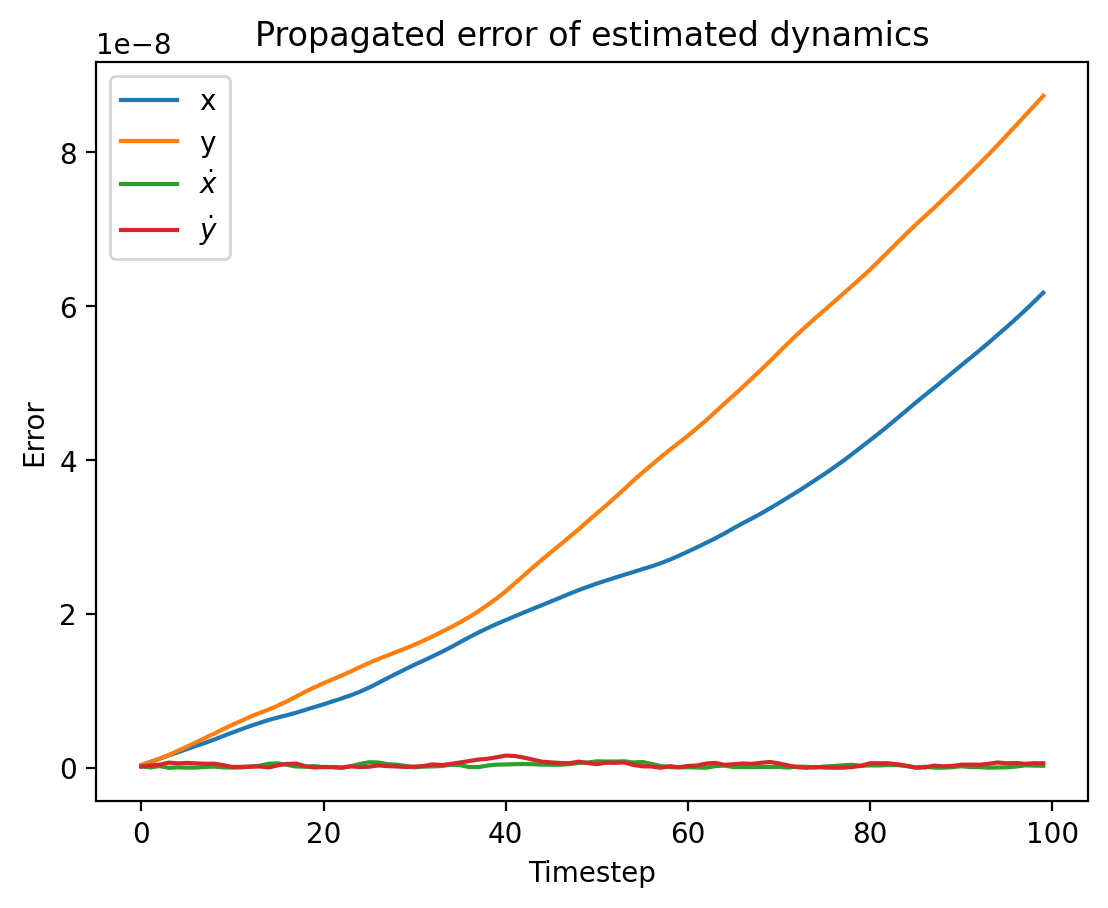

In [10]:
plt.figure(dpi=200)
plt.plot(ex_traj[0, :], label="x")
plt.plot(ex_traj[1, :], label="y")
plt.plot(ex_traj[2, :], label="$ \dot{x} $")
plt.plot(ex_traj[3, :], label="$ \dot{y} $")
plt.xlabel("Timestep")
plt.ylabel("Error")
plt.title("Propagated error of estimated dynamics")
plt.legend()